# 2. Liquidity Distribution Analysis

We will analyze the distribution of the ETH/MORPHO UniV4 pool to:
1. Pull and visualize current liquidity distribution across tick ranges
2. Analyze how liquidity concentration explains slippage behavior from Question 1
3. Demonstrate why total TVL alone is insufficient for predicting execution quality

In [9]:
import os
import sys
from web3 import Web3
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("..")

from src.config import STATE_VIEW, POOL_ID_BYTES, POOL_ID, TICK_SPACING
from src.abis import STATEVIEW_ABI_EXTENDED
from src.liquidity_distribution import fetch_liquidity_distribution
from src.tvl import fetch_pool_tvl_graphql

In [10]:
# Connect to RPC
load_dotenv()
url = os.getenv('rpc_url_mainnet')
w3 = Web3(Web3.HTTPProvider(url))

if not w3.is_connected():
    raise Exception('Could not connect to RPC')
else:
    print('Connected to Ethereum mainnet')

Connected to Ethereum mainnet


## 2.1 Pull Liquidity Distribution from V4 Singleton and plot

We scan the tick bitmap to find all initialized ticks, then calculate the liquidity in each tick range.

In [11]:
# Convert to checksum address and create contract instance
STATE_VIEW_CS = Web3.to_checksum_address(STATE_VIEW)
stateview = w3.eth.contract(address=STATE_VIEW_CS, abi=STATEVIEW_ABI_EXTENDED)

# Fetch liquidity distribution via bitmap scanning
print("Scanning tick bitmap and building liquidity distribution...")
df, slot = fetch_liquidity_distribution(stateview, POOL_ID_BYTES, TICK_SPACING, search_range=100)

print(f"\nCurrent tick: {slot['tick']}")
print(f"Current liquidity: {slot['liquidity']:,}")
print(f"Tick ranges found: {len(df)}")
print(f"\n{df}")

Scanning tick bitmap and building liquidity distribution...

Current tick: 78410
Current liquidity: 42,423,766,391,108,996,091,256
Tick ranges found: 20

    tick_lower  tick_upper          active_liquidity
0      -887280     -887220                         0
1      -887220       62160        104617165570455737
2        62160       68880     252711790937186347042
3        68880       69000   42618930390706886516956
4        69000       73080   42641294988035805748529
5        73080       73800   42782351631143934509014
6        73800       74280   42834087591852302635309
7        74280       74820  136118145787185550199097
8        74820       75360  135865538613413934307792
9        75360       76200  136252687904016036010100
10       76200       76260  136093547567819520234839
11       76260       76560  136095726463162222689974
12       76560       76680  135954669820054093929489
13       76680       77880  135952490924711391474354
14       77880       78180  13554868425024572787978

Expanded from 20 ranges to 29573 ticks
Min non-zero liquidity: 104617165570455737
     tick    active_liquidity  liquidity_normalized
0 -887280                   0                   0.0
1 -887220  104617165570455737                   1.0
2 -887160  104617165570455737                   1.0
3 -887100  104617165570455737                   1.0
4 -887040  104617165570455737                   1.0


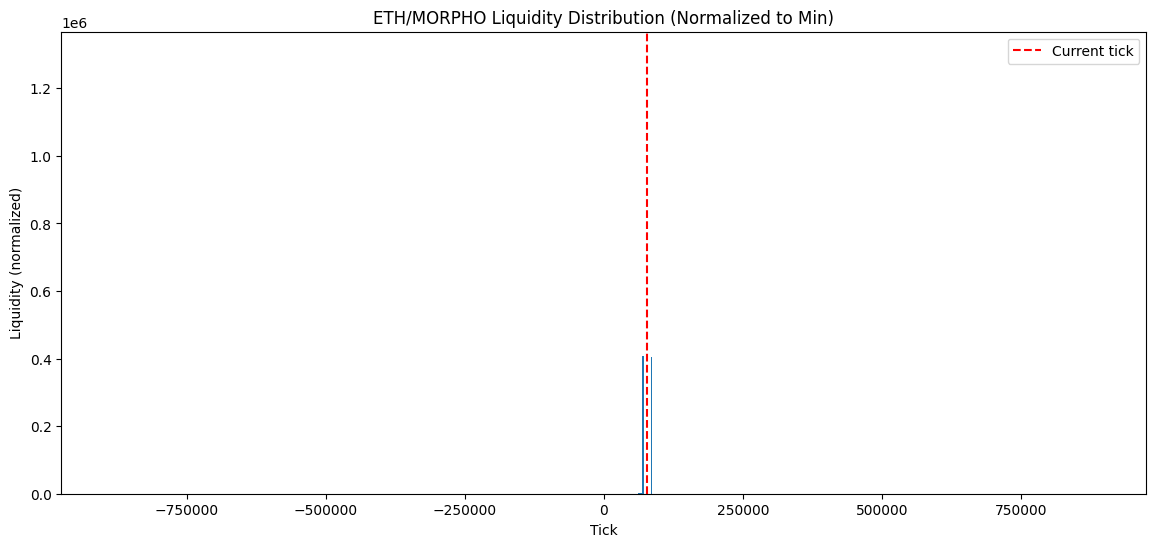

In [12]:
# Expand DataFrame to one row per tick_spacing
# This creates a "larger" df with uniform tick intervals
expanded_rows = []
for _, row in df.iterrows():
    for tick in range(int(row["tick_lower"]), int(row["tick_upper"]), TICK_SPACING):
        expanded_rows.append({
            "tick": tick,
            "active_liquidity": row["active_liquidity"]
        })

df_expanded = pd.DataFrame(expanded_rows)

# Normalize by minimum non-zero value
min_nonzero = df_expanded[df_expanded["active_liquidity"] > 0]["active_liquidity"].min()
df_expanded["liquidity_normalized"] = df_expanded["active_liquidity"].astype(float) / float(min_nonzero)

print(f"Expanded from {len(df)} ranges to {len(df_expanded)} ticks")
print(f"Min non-zero liquidity: {min_nonzero}")
print(df_expanded.head(5))

# Bar chart with normalized liquidity values
plt.figure(figsize=(14, 6))
plt.bar(df_expanded["tick"], df_expanded["liquidity_normalized"], width=TICK_SPACING * 0.9)
plt.axvline(slot["tick"], color="red", linestyle="--", label="Current tick")
plt.title("ETH/MORPHO Liquidity Distribution (Normalized to Min)")
plt.xlabel("Tick")
plt.ylabel("Liquidity (normalized)")
plt.legend()
plt.savefig("plots/liquidity_normalized.png", bbox_inches="tight")
plt.show()

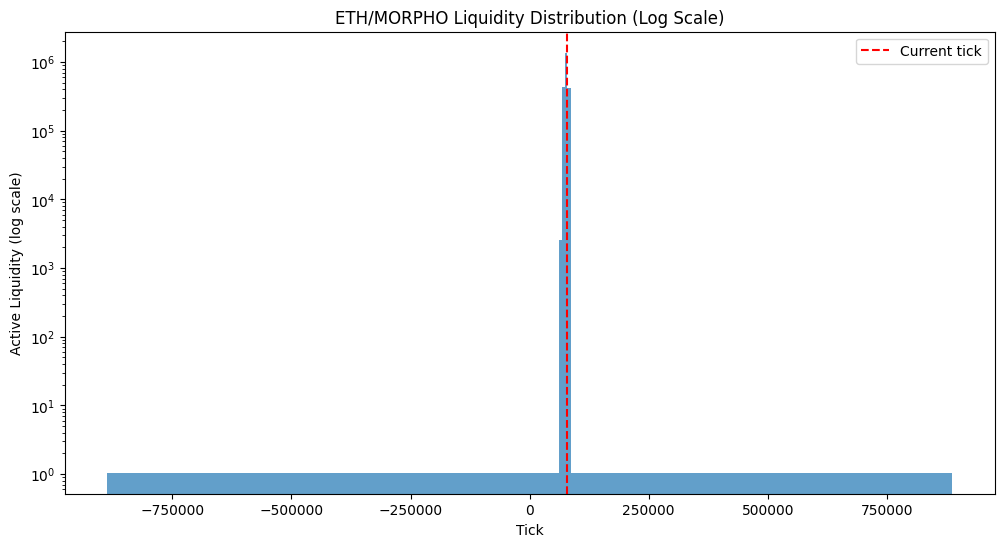

In [13]:
# Step plot with logarithmic scale - Y-axis shows the scaled liq_Scale values
# Shows true liquidity profile - useful for seeing both small and large values
liq_scaled = df["active_liquidity"].astype(float) / 1e17

plt.figure(figsize=(12, 6))
edges = list(df["tick_lower"]) + [df["tick_upper"].iloc[-1]]
plt.stairs(liq_scaled, edges=edges, fill=True, alpha=0.7)
plt.axvline(slot["tick"], color="red", linestyle="--", label="Current tick")
plt.yscale("log")
plt.title("ETH/MORPHO Liquidity Distribution (Log Scale)")
plt.xlabel("Tick")
plt.ylabel("Active Liquidity (log scale)")
plt.legend()
plt.savefig("plots/liquidity_log_scale.png", bbox_inches="tight")
plt.show()

## 2.2 Analyze Concentrated Liquidity Slippage

### Concentrated Liquidity Invariant (Uniswap V3/V4)

For liquidity $L$ active over price range $[p_a, p_b]$, V3/V4 satisfies:

$$\left(x + \frac{L}{\sqrt{p_b}}\right)\left(y + L\sqrt{p_a}\right) = L^2$$

Define virtual reserves: $X_v = x + \frac{L}{\sqrt{p_b}}$, $Y_v = y + L\sqrt{p_a}$

Then: $X_v \cdot Y_v = L^2$ (formally identical to V2, but with shifted reserves)

### Deriving Token Balances x(p) and y(p)

From price $p = Y_v / X_v$ and invariant $X_v Y_v = L^2$, by substituting $X_v$ or $Y_v$ in $X_v Y_v = L^2$, we get:

$$X_v = \frac{L}{\sqrt{p}}, \quad Y_v = L\sqrt{p}$$

Recover real reserves by substituting $X_v = \frac{L}{\sqrt{p}}$ and $Y_v = L\sqrt{p}$ into $x = X_v - \frac{L}{\sqrt{p_b}}$ and $y = Y_v - L\sqrt{p_a}.$

$$x(p) = L\left(\frac{1}{\sqrt{p}} - \frac{1}{\sqrt{p_b}}\right)$$

$$y(p) = L\left(\sqrt{p} - \sqrt{p_a}\right)$$

### Slippage V3/V4

Assuming the price $p$ lies strictly inside the active range $[p_a, p_b]$, so the liquidity $L$ is constant during the trade.

Consider a swap of $\Delta x > 0$ units of token0.

$$
x(p') = x(p) + \Delta x,
$$

where $p'$ is the new price after the trade.

We substitute the expression for $x(\cdot)$, from above:

$$
L\left(\frac{1}{\sqrt{p'}} - \frac{1}{\sqrt{p_b}}\right) = L\left(\frac{1}{\sqrt{p}} - \frac{1}{\sqrt{p_b}}\right) + \Delta x.
$$

Divide both sides by $L$ and have $-\frac{1}{\sqrt{p_b}}$ cancel out:

$$
\frac{1}{\sqrt{p'}} = \frac{1}{\sqrt{p}} + \frac{\Delta x}{L}.
$$

Invert both sides:

$$
\sqrt{p'} = \frac{1}{\dfrac{1}{\sqrt{p}} + \dfrac{\Delta x}{L}}.
$$

Multiply $\frac{\sqrt{p}}{\sqrt{p}}$:

$$
\sqrt{p'} = \frac{\sqrt{p}}{1 + \dfrac{\Delta x\sqrt{p}}{L}}.
$$

Square both sides to obtain the new price:

$$
p' = \frac{p}{\left(1 + \dfrac{\Delta x\sqrt{p}}{L}\right)^2}.
$$

We can see that if **$L$ is large $p'  \approx p$**

### Slippage: V2 vs V3/V4

$$
\text{V2 slippage:}\quad
|\text{slippage}_{\text{V2}}|
= \frac{\Delta x}{X + \Delta x}
$$

$$
\text{V3/V4 slippage (single tick):}\quad
|\text{slippage}_{\text{V3/V4}}|
= 1 -
\frac{1}{\left(1 + \dfrac{\Delta x \sqrt{p}}{L}\right)^2}
$$

- V2 slippage depends on **total reserve** $X$
- V3/V4 slippage depends on **local liquidity** $L$ at the current tick

## Visualize the liquidity patterns

We demonstrate that execution quality depends on **local liquidity distribution**, not just total TVL.

In [14]:
# Calculate slippage for various trade sizes to show tick-crossing effects
from src.slippage import calculate_slippage
from src.config import QUOTER, ETH, MORPHO, FEE, HOOKS
from src.abis import QUOTER_ABI

# Convert addresses to checksum format
QUOTER_CS = Web3.to_checksum_address(QUOTER)
ETH_CS = Web3.to_checksum_address(ETH)
MORPHO_CS = Web3.to_checksum_address(MORPHO)
HOOKS_CS = Web3.to_checksum_address(HOOKS)

# Fetch actual TVL from GraphQL for V2 theoretical comparison
print("Fetching pool TVL from GraphQL...")
graphql_data = fetch_pool_tvl_graphql(POOL_ID)
total_tvl_usd = float(graphql_data.get("totalLiquidity", {}).get("value", 0))
eth_supply = graphql_data.get("token0Supply", 0) or 0
print(f"Pool TVL: ${total_tvl_usd:,.2f}")
print(f"ETH in pool: {eth_supply:,.2f}")

# Trade sizes that will cross tick boundaries
trade_sizes_eth = [1, 5, 10, 25, 50]

results = []
for eth_amount in trade_sizes_eth:
    amount_wei = int(eth_amount * 1e18)
    result = calculate_slippage(
        w3, amount_wei,
        STATE_VIEW_CS, STATEVIEW_ABI_EXTENDED,
        QUOTER_CS, QUOTER_ABI,
        POOL_ID_BYTES,
        ETH_CS, MORPHO_CS,
        FEE, TICK_SPACING, HOOKS_CS,
        zero_for_one=True  # ETH -> MORPHO
    )
    result["trade_size_eth"] = eth_amount
    results.append(result)

df_slippage = pd.DataFrame(results)
print(f"\n{df_slippage[['trade_size_eth', 'slippage_percentage']]}")

Fetching pool TVL from GraphQL...
Pool TVL: $3,182,093.34
ETH in pool: 353.66

   trade_size_eth  slippage_percentage
0               1             0.417889
1               5             0.887067
2              10             1.466970
3              25             2.458166
4              50             3.488543


Using ETH TVL for V2: 353.66 ETH

ETH    Actual %   V2 %       V3/V4 Curr   V3/V4 Per-Pt Exec Tick    Band              
----------------------------------------------------------------------------------------------------
1      0.4179     0.2820     0.2373       0.2373       78368        [78360, 79020)    
5      0.8871     1.3941     1.1779       1.1779       78321        N/A               
10     1.4670     2.7498     2.3351       2.3351       78262        N/A               
25     2.4582     6.6022     5.6872       1.8341       78161        [77880, 78180)    
50     3.4885     12.3866    10.9028      3.6181       78055        [77880, 78180)    


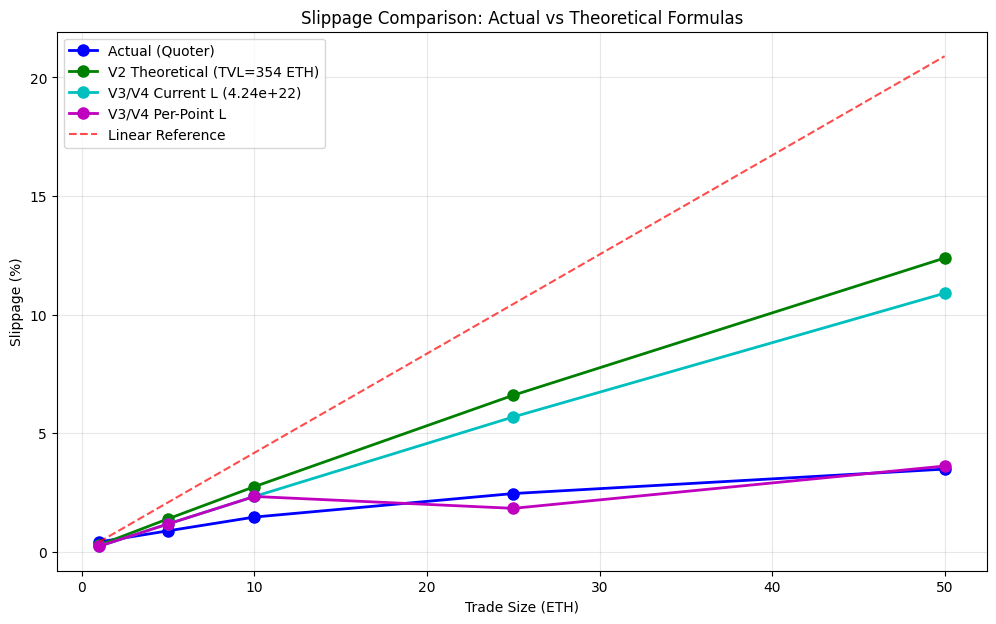

In [15]:
# Compare actual slippage vs theoretical formulas (V2 and V3/V4)

# Helper function to find liquidity at a given tick
def get_liquidity_at_tick(df, tick):
    """Find the liquidity for the band containing the given tick."""
    band = df[(df["tick_lower"] <= tick) & (df["tick_upper"] > tick)]
    if not band.empty:
        return float(band["active_liquidity"].values[0]), int(band["tick_lower"].values[0]), int(band["tick_upper"].values[0])
    return None, None, None

# Get current price and liquidity for V3/V4 formula
current_price = 1.0001 ** slot["tick"]  # price from tick
current_L = float(slot["liquidity"])
sqrt_p = np.sqrt(current_price)

eth_amounts = df_slippage["trade_size_eth"].values
actual_slippages = df_slippage["slippage_percentage"].values

# V2: slippage ≈ Δx / (X + Δx) where X is total ETH reserve (from GraphQL)
tvl_eth = eth_supply if eth_supply > 0 else 500  # fallback only if API fails
print(f"Using ETH TVL for V2: {tvl_eth:.2f} ETH")
v2_theoretical = [dx / (tvl_eth + dx) * 100 for dx in eth_amounts]

# V3/V4 with constant current L (original approach)
#Converting dx to wei ensures dimensional consistency in the formula
v3v4_current_L = [(1 - 1 / (1 + (dx * 1e18) * sqrt_p / current_L)**2) * 100 for dx in eth_amounts]

# V3/V4: Calculate per-point using liquidity at the execution tick
v3v4_per_point = []
band_info = []  # Track which band was used for each point

for i, result in enumerate(results):
    # Derive execution tick from execution price (amount_out/amount_in)
    exec_price = result["amount_out_wei"] / result["amount_in_wei"]
    exec_tick = int(np.log(exec_price) / np.log(1.0001))

    # Find band liquidity at that tick
    band_L, tick_lower, tick_upper = get_liquidity_at_tick(df, exec_tick)
    if band_L is None:
        band_L = current_L  # fallback
        tick_lower, tick_upper = "N/A", "N/A"

    # Calculate theoretical slippage using that band's L
    dx = result["trade_size_eth"]
    theoretical = (1 - 1 / (1 + (dx * 1e18) * sqrt_p / band_L)**2) * 100
    v3v4_per_point.append(theoretical)
    band_info.append((exec_tick, tick_lower, tick_upper, band_L))

# Linear reference (what slippage would be if it scaled linearly)
linear_ref = [actual_slippages[0] * (dx / eth_amounts[0]) for dx in eth_amounts]

# Plot all together
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(eth_amounts, actual_slippages, 'bo-', linewidth=2, markersize=8, label='Actual (Quoter)')
ax.plot(eth_amounts, v2_theoretical, 'go-', linewidth=2, markersize=8, label=f'V2 Theoretical (TVL={tvl_eth:.0f} ETH)')
ax.plot(eth_amounts, v3v4_current_L, 'co-', linewidth=2, markersize=8, label=f'V3/V4 Current L ({current_L:.2e})')
ax.plot(eth_amounts, v3v4_per_point, 'mo-', linewidth=2, markersize=8, label='V3/V4 Per-Point L')
ax.plot(eth_amounts, linear_ref, 'r--', linewidth=1.5, alpha=0.7, label='Linear Reference')

ax.set_xlabel('Trade Size (ETH)')
ax.set_ylabel('Slippage (%)')
ax.set_title('Slippage Comparison: Actual vs Theoretical Formulas')
ax.legend()
ax.grid(True, alpha=0.3)

# Print comparison table with band info
print(f"\n{'ETH':<6} {'Actual %':<10} {'V2 %':<10} {'V3/V4 Curr':<12} {'V3/V4 Per-Pt':<12} {'Exec Tick':<12} {'Band':<18}")
print("-" * 100)
for i, (eth, actual, v2, v3_curr, v3_pt) in enumerate(zip(eth_amounts, actual_slippages, v2_theoretical, v3v4_current_L, v3v4_per_point)):
    exec_tick, tick_lo, tick_hi, band_L = band_info[i]
    band_str = f"[{tick_lo}, {tick_hi})" if tick_lo != "N/A" else "N/A"
    print(f"{eth:<6} {actual:<10.4f} {v2:<10.4f} {v3_curr:<12.4f} {v3_pt:<12.4f} {exec_tick:<12} {band_str:<18}")

plt.savefig("plots/slippage_formula_comparison.png", bbox_inches="tight")
plt.show()

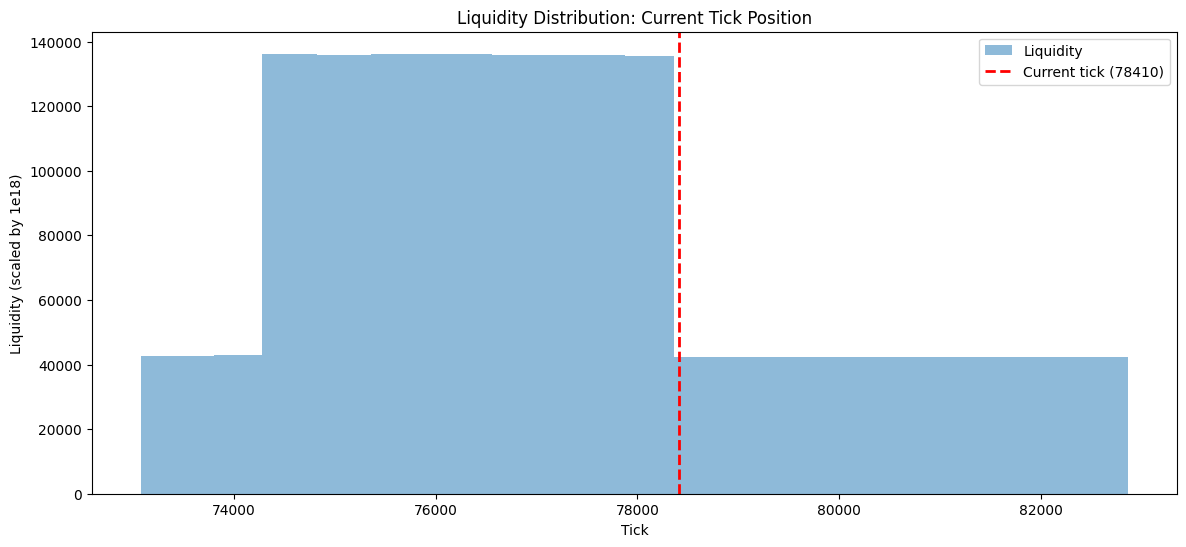


Current tick 78410 is in band [78360, 79020)
  Liquidity: 42,423,766,391,108,992,499,712

Trade execution tick progression:
  1 ETH -> exec tick 78368 in band [78360, 79020) with L = 4.24e+22
  5 ETH -> exec tick 78321 in band [N/A, N/A) with L = 4.24e+22
  10 ETH -> exec tick 78262 in band [N/A, N/A) with L = 4.24e+22
  25 ETH -> exec tick 78161 in band [77880, 78180) with L = 1.36e+23
  50 ETH -> exec tick 78055 in band [77880, 78180) with L = 1.36e+23


In [16]:
# Zoomed liquidity chart showing current tick position relative to liquidity bands
fig, ax = plt.subplots(figsize=(14, 6))

# Filter to relevant tick range (dynamically based on current tick)
current_tick = slot["tick"]
zoom_margin = 8000  # ticks on each side
tick_min = current_tick - zoom_margin
tick_max = current_tick + zoom_margin
df_zoom = df[(df["tick_lower"] >= tick_min) & (df["tick_upper"] <= tick_max)]

if not df_zoom.empty:
    edges_zoom = list(df_zoom["tick_lower"]) + [df_zoom["tick_upper"].iloc[-1]]
    liq_zoom = df_zoom["active_liquidity"].astype(float) / 1e18

    ax.stairs(liq_zoom, edges=edges_zoom, fill=True, alpha=0.5, label="Liquidity")
    ax.axvline(current_tick, color="red", linestyle="--", linewidth=2, label=f"Current tick ({current_tick})")

    ax.set_xlabel("Tick")
    ax.set_ylabel("Liquidity (scaled by 1e18)")
    ax.set_title("Liquidity Distribution: Current Tick Position")
    ax.legend()
    plt.savefig("plots/liquidity_tick_crossing.png", bbox_inches="tight")
    plt.show()
else:
    print("No liquidity data in zoom range")

# Print key observations
current_band_L, current_lo, current_hi = get_liquidity_at_tick(df, current_tick)
if current_band_L:
    print(f"\nCurrent tick {current_tick} is in band [{current_lo}, {current_hi})")
    print(f"  Liquidity: {current_band_L:,.0f}")

# Show how trades move through bands
print("\nTrade execution tick progression:")
for i, (exec_tick, tick_lo, tick_hi, band_L) in enumerate(band_info):
    eth = eth_amounts[i]
    print(f"  {eth} ETH -> exec tick {exec_tick} in band [{tick_lo}, {tick_hi}) with L = {band_L:.2e}")

## 2.3 Why Total TVL Is Insufficient

In **V2** liquidity is spread uniformly across all prices. TVL = total reserves, slippage depends on total pool size. But in **V3/V4** liquidity is *concentrated* in specific tick ranges. Each band has its own L value. 

The TVL as an approximation does not change by the amount traded as TVL does not change. The V3/V4 slippage on the other hand depends on **local liquidity** L, not total reserves and as trades move price through different bands, they encounter different L values. Therefore, the "V3/V4 Per-Point L" line (magenta) tracks actual slippage better than constant L because it uses the liquidity at each execution price